In [1]:
from pathlib import Path

PROJECT_ROOT = Path.cwd()
RAW_DATA_DIR = PROJECT_ROOT / "Datasets" / "Korean child & Pins dataset"
PROCESSED_ROOT = RAW_DATA_DIR / "processed_split"
TRAIN_DIR = PROCESSED_ROOT / "train"
TEST_DIR = PROCESSED_ROOT / "test"
DETECTED_FACES_DIR = PROJECT_ROOT / "train_detected_faces"
EMBEDDINGS_DIR = PROJECT_ROOT / "extracted_embeddings"
EMBEDDINGS_TEST_DIR = PROJECT_ROOT / "extracted_embeddingstest"

for directory in [RAW_DATA_DIR, PROCESSED_ROOT, TRAIN_DIR, TEST_DIR, DETECTED_FACES_DIR, EMBEDDINGS_DIR, EMBEDDINGS_TEST_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"Project root        : {PROJECT_ROOT}")
print(f"Raw dataset directory: {RAW_DATA_DIR}")
print(f"Processed output dir : {PROCESSED_ROOT}")
print(f"Detected faces dir   : {DETECTED_FACES_DIR}")
print(f"Embeddings dir       : {EMBEDDINGS_DIR}")
print(f"Embeddings test dir  : {EMBEDDINGS_TEST_DIR}")

Project root        : /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application
Raw dataset directory: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Korean child & Pins dataset
Processed output dir : /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Korean child & Pins dataset/processed_split
Detected faces dir   : /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/train_detected_faces
Embeddings dir       : /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddings
Embeddings test dir  : /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddingstest


   ![fig8.png](attachment:9d6e0a58-a1a4-44f8-8d80-8a3dd3044ba5.png)


## INTRODUCTION

In [2]:
if not RAW_DATA_DIR.exists():
    raise FileNotFoundError(f'Expected dataset directory missing: {RAW_DATA_DIR}')
else:
    print('Dataset directory found. Ready to proceed with face detection and recognition pipeline.')

Dataset directory found. Ready to proceed with face detection and recognition pipeline.


Face detection and face recognition are two related but distinct tasks in the field of computer vision and image processing.

Face Detection:

Objective: The primary goal of face detection is to locate and identify faces within an image or a video stream.

Process:

Face detection algorithms analyze the input image to identify regions or bounding boxes containing faces. These algorithms don't necessarily recognize whose face it is; they only detect the presence and location of faces.

Techniques:

Various techniques are used for face detection, including traditional methods like Haar cascades and more advanced methods using deep learning, such as Single Shot MultiBox Detector (SSD) or Faster R-CNN.


Face Recognition:

Objective:

Face recognition, on the other hand, involves identifying and verifying a person's identity based on their facial features. It associates detected faces with specific individuals whose identities are known.

Process:

Face recognition systems capture facial features, create a unique representation or "embedding" of each face, and then compare these embeddings to a database of known faces for identification or verification purposes.

Techniques:

Deep learning approaches, especially convolutional neural networks (CNNs), have proven effective for face recognition. Embeddings from face recognition models, like those trained on FaceNet or VGGFace, enable accurate comparisons between faces.

In summary, face detection is the initial step that locates faces within an image, while face recognition goes a step further by identifying and verifying the individuals associated with those faces. Both tasks have numerous applications, including security systems, surveillance, user authentication, and human-computer interaction. Advances in deep learning have significantly improved the accuracy and robustness of face detection and recognition systems.

We are given datasets of images that are already labeled and our goal will be to set up a face recognition process by detecting faces first and extracting its features. We will be implementing multiple approaches. Recognition by using the distance between embeddings and recognition by training the embeddings and evaluating unseen embeddings for classification/recognition. Its importatnt to note that we will a lot of images with high quality for the models to work accurately.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from matplotlib import pyplot as plt


review folder names and file counts

In [4]:
main_directory = RAW_DATA_DIR
folder_count = 0
total_file_count = 0

for root, dirs, files in os.walk(main_directory):
    folder_count += len(dirs)
    folder_file_count = len(files)
    total_file_count += folder_file_count

    print(f"Folder: {Path(root).name}, Files: {folder_file_count}")

print(f"\nNumber of folders: {folder_count}")
print(f"Total number of files: {total_file_count}")

Folder: Korean child & Pins dataset, Files: 0
Folder: pins_Kim-Sol-Mae, Files: 41
Folder: pins_Alvaro Morte, Files: 139
Folder: Pins_Ruda, Files: 72
Folder: pins_Adriana Lima, Files: 213
Folder: processed_split, Files: 0
Folder: train, Files: 0
Folder: test, Files: 0
Folder: pins_Andy Samberg, Files: 196
Folder: pins_Amanda Crew, Files: 117
Folder: pins_alycia dabnem carey, Files: 211
Folder: pins_Anne Hathaway, Files: 203
Folder: pins_amber heard, Files: 218
Folder: pins_Alexandra Daddario, Files: 225
Folder: pins_Alex Lawther, Files: 152

Number of folders: 14
Total number of files: 1787


## DEMONSTRATING TECHNIQUES and EXPLAINING TERMINOLOGY

Below you will see demos of face detection, face embeddings and face landmarks.

Randomly pick few images and display - images are mostly close ups but to ensure more accurate face recognition, we will apply face detection before processing for face recogntion.

['pins_Kim-Sol-Mae', 'pins_Alvaro Morte', 'Pins_Ruda', 'pins_Adriana Lima', 'processed_split', 'pins_Andy Samberg', 'pins_Amanda Crew', 'pins_alycia dabnem carey', 'pins_Anne Hathaway', 'pins_amber heard', 'pins_Alexandra Daddario', 'pins_Alex Lawther']
No images found in processed_split


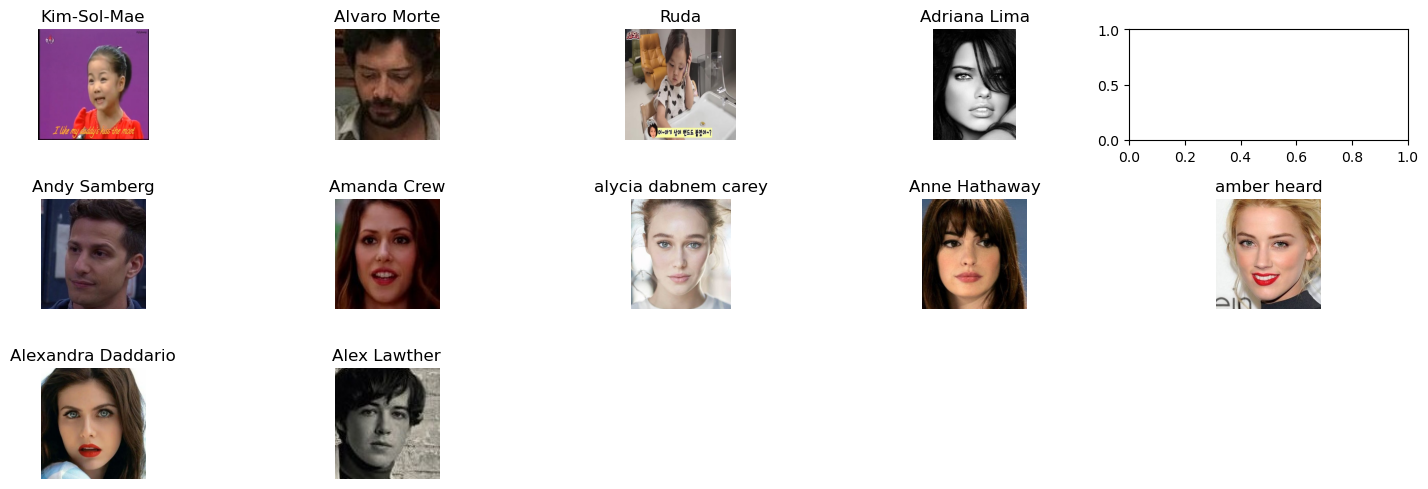

In [5]:
# Get a list of all folders
all_folders = [folder for folder in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, folder))]

selected_folders = all_folders

print(selected_folders)

# Calculate the number of rows and columns dynamically
num_folders = len(selected_folders)
cols = 5
rows = (num_folders + cols - 1) // cols  # Calculate rows needed

# Create a grid for displaying images
fig, axes = plt.subplots(rows, cols, figsize=(15, 5))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Iterate through selected folders and display one random image from each folder
for i, folder in enumerate(selected_folders):
    folder_path = os.path.join(main_directory, folder)
    all_images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

    if not all_images:
        print(f"No images found in {folder}")
        continue

    # Randomly pick one image
    selected_image = random.choice(all_images)

    # Get the full path to the selected image
    image_path = os.path.join(folder_path, selected_image)

    # Read and display the image
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

    # Extract label from folder name and drop the first 5 characters
    label = folder[5:]
    axes[i].set_title(label)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


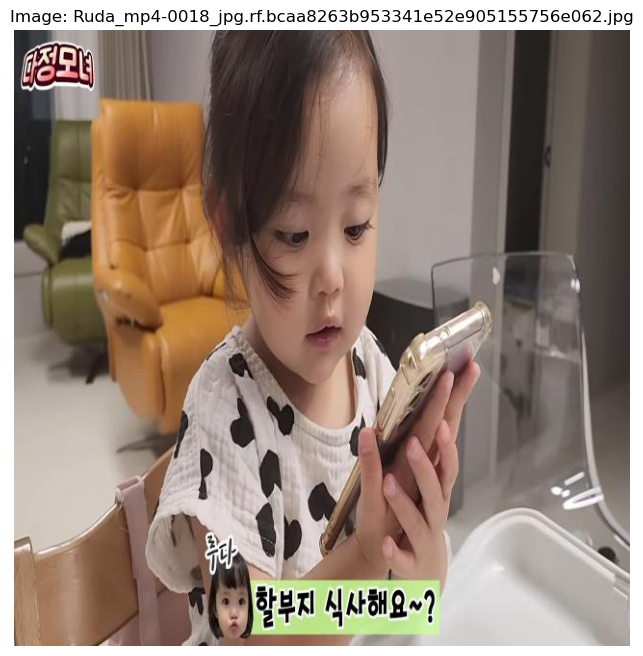

In [6]:
selected_folder = RAW_DATA_DIR / 'Pins_Ruda'

all_images = [img for img in os.listdir(selected_folder) if img.lower().endswith('.jpg')]

if not all_images:
    print("No .jpg images found in the specified folder.")
else:
    selected_image = random.choice(all_images)
    image_path = selected_folder / selected_image

    img = mpimg.imread(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {selected_image}")
    plt.show()

In [7]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.9 MB ? eta -:--:--Collecting lz4>=4.3.3 (from mtcnn)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.6 MB/s eta 0:00:00


We randomly pick one image and apply face detection for demonstration purposes using MTCNN library. Face detection is a crucial pre-processing step before face recognition for several reasons:

Localization of Faces:

Identification of Regions of Interest (ROI): Face detection helps identify and locate the regions of an image or video frame that contain faces. This is essential for isolating the facial features from the rest of the scene.

Efficiency:

Reducing Computation: Face detection significantly reduces the computational load for subsequent face recognition tasks. By focusing on areas containing faces, the algorithm doesn't need to process the entire image, making the recognition process more efficient.
Accuracy:

Enhanced Accuracy: When a face recognition algorithm operates on pre-detected faces, it can achieve higher accuracy. This is because the algorithm can concentrate on analyzing facial features without being distracted by irrelevant background information.
Handling Multiple Faces:

Dealing with Multiple Faces: In scenarios where there are multiple individuals in an image or video frame, face detection helps identify and isolate each face, enabling the face recognition system to process one face at a time.

Improving Speed:

Real-time Applications: In real-time applications, such as video surveillance or live streaming, the speed of face detection allows for faster processing and identification of individuals. This is especially critical in time-sensitive applications, such as security and access control.

Noise Reduction:

Filtering Out Non-Facial Elements: Face detection helps filter out non-facial elements, such as objects or complex backgrounds, that might interfere with the face recognition process. This noise reduction contributes to the overall accuracy of the face recognition system.
Privacy Considerations:

Minimizing Privacy Concerns: By detecting faces first, privacy concerns can be addressed more effectively. Face detection can be used to ensure that facial recognition is applied only when necessary and within the appropriate context.

Resource Optimization:

Optimizing Resource Usage: Face detection allows for the allocation of resources only to areas containing faces, optimizing memory and processing power. This is particularly important in resource-constrained environments.

In [8]:
pip install lz4

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2025-10-01 00:36:37.742769: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-01 00:36:37.755352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759246597.770066 1706070 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759246597.774713 1706070 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759246597.786006 1706070 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

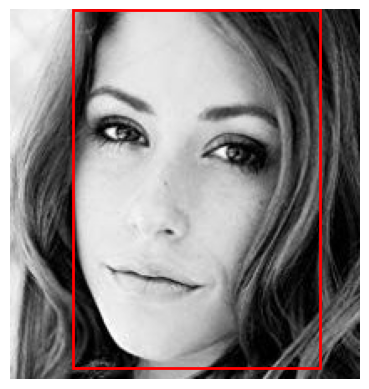

Visualized faces for: Datasets/Korean child & Pins dataset/pins_Amanda Crew/Amanda Crew62_94.jpg


In [9]:
import matplotlib.patches as patches
from mtcnn import MTCNN


def detect_and_display_faces(image_path: Path) -> None:
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    detector = MTCNN()
    faces = detector.detect_faces(img_rgb)

    fig, ax = plt.subplots()
    ax.imshow(img_rgb)

    for face in faces:
        x, y, w, h = face['box']
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()


all_folders = [folder for folder in os.listdir(main_directory) if (main_directory / folder).is_dir()]
selected_folder = random.choice(all_folders)
folder_path = main_directory / selected_folder

all_images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]
selected_image = random.choice(all_images)
image_path = folder_path / selected_image

detect_and_display_faces(image_path)
print(f"Visualized faces for: {image_path.relative_to(PROJECT_ROOT)}")

In [10]:
import os

# Define the path for the processed dataset root
new_folder_path = str(PROCESSED_ROOT)

# Create the folder if it does not exist
os.makedirs(new_folder_path, exist_ok=True)

print(f"Folder created at: {new_folder_path}")

Folder created at: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Korean child & Pins dataset/processed_split


We will be copying around 100 images from each folder to another folder to apply preprocessing steps and also do a train/test split.

In [11]:
import os
import shutil
import random

# Source directory
source_directory = RAW_DATA_DIR

# Destination directory
destination_directory = PROCESSED_ROOT

# Create train directory if not exist
train_directory = TRAIN_DIR
train_directory.mkdir(parents=True, exist_ok=True)

# Get a list of all folders in the source directory
all_folders = [folder for folder in os.listdir(source_directory) if (source_directory / folder).is_dir()]

print(all_folders)

# Iterate through each folder
for folder in all_folders:
    folder_path = source_directory / folder

    # Get a list of all images in the folder
    all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(".jpg")]

    # Create a label for the folder (drop the first 5 characters)
    label = folder[5:]

    print(label, "\n")

    # Shuffle the images
    random.shuffle(all_images)

    # Calculate the number of images to copy (85%)
    num_images_to_copy = int(len(all_images) * 0.85)

    # Copy 85% of the images to the train directory
    for i in range(num_images_to_copy):
        image_path = folder_path / all_images[i]
        destination_path = train_directory / label / all_images[i]
        destination_path.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy(image_path, destination_path)

print("Data splitting completed.")

['pins_Kim-Sol-Mae', 'pins_Alvaro Morte', 'Pins_Ruda', 'pins_Adriana Lima', 'processed_split', 'pins_Andy Samberg', 'pins_Amanda Crew', 'pins_alycia dabnem carey', 'pins_Anne Hathaway', 'pins_amber heard', 'pins_Alexandra Daddario', 'pins_Alex Lawther']
Kim-Sol-Mae 

Alvaro Morte 

Ruda 

Adriana Lima 

ssed_split 

Andy Samberg 

Amanda Crew 

alycia dabnem carey 

Anne Hathaway 

amber heard 

Alexandra Daddario 

Alex Lawther 

Data splitting completed.


MTCNN (Multi-task Cascaded Convolutional Networks) is a popular deep learning-based face detection algorithm. It's designed to detect faces and their facial landmarks in an image. MTCNN is widely used in computer vision applications and is known for its ability to efficiently and accurately locate faces in various settings.

The MTCNN algorithm consists of three stages:

Face Detection:

The first stage identifies candidate regions containing faces using a convolutional neural network (CNN). This stage produces a set of bounding boxes that may contain faces.
Bounding Box Refinement:

The second stage refines the bounding boxes obtained in the first stage. It involves further processing to improve the accuracy of the face location by adjusting the coordinates of the bounding boxes.
Facial Landmark Localization:

The third stage is responsible for identifying facial landmarks, such as the eyes, nose, and mouth, within the detected faces. This stage provides additional information about the facial structure.

Again for demonstration, we will randomly pick two images, apply face detection, define bounding box on the face and identify facial landmarks. You can also observe how the landmarks are plotted on the face with their coordinates shown on the picture frame below. Capturing landmarks are important especially for tasks like emotion detection where we need specific features extracted from each face to for training purposes.

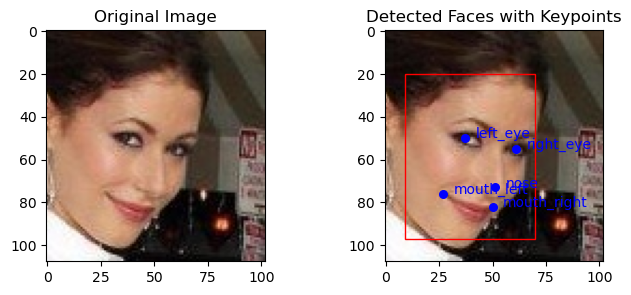

Metadata of detected faces in Amanda Crew/Amanda Crew224_57.jpg:
Face 1:
   Confidence: 0.99
   Bounding Box: [9, 20, 61, 77]
   Keypoints: {'nose': [51, 73], 'mouth_right': [50, 82], 'right_eye': [61, 55], 'left_eye': [37, 50], 'mouth_left': [27, 76]}



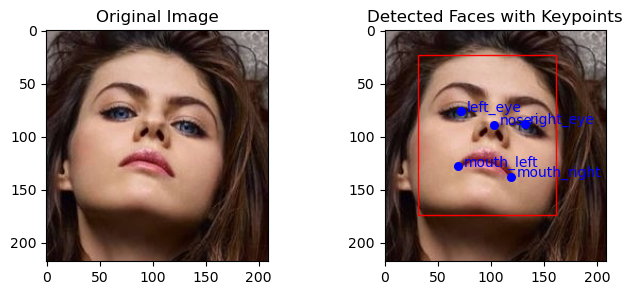

Metadata of detected faces in Alexandra Daddario/Alexandra Daddario189_299.jpg:
Face 1:
   Confidence: 1.00
   Bounding Box: [31, 23, 130, 151]
   Keypoints: {'nose': [103, 89], 'mouth_right': [119, 138], 'right_eye': [132, 88], 'left_eye': [72, 76], 'mouth_left': [69, 128]}



In [17]:
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN

# Directory paths
train_directory = TRAIN_DIR

# Get a list of all folders in the train directory
all_folders = [folder for folder in train_directory.iterdir() if folder.is_dir()]

# Randomly select two folders
selected_folders = random.sample(all_folders, 2)

# Initialize MTCNN detector
detector = MTCNN()

# Iterate through selected folders
for folder in selected_folders:
    # Get a list of all images in the folder
    all_images = [img for img in folder.iterdir() if img.suffix.lower() == ".jpg"]

    if not all_images:
        continue

    # Randomly select one image
    selected_image = random.choice(all_images)

    # Read the image
    image = cv2.imread(str(selected_image))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces using MTCNN
    faces = detector.detect_faces(image)

    # Display image with bounding boxes around detected faces
    plt.figure(figsize=(8, 3))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")

    # Display image with bounding boxes
    plt.subplot(1, 2, 2)
    plt.imshow(image_rgb)

    for face in faces:
        x, y, width, height = face['box']
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        plt.gca().add_patch(rect)

        # Display additional keypoints
        for key, value in face['keypoints'].items():
            plt.scatter(value[0], value[1], s=30, color='blue', marker='o')
            plt.text(value[0] + 5, value[1], key, color='blue')

    plt.title('Detected Faces with Keypoints')
    plt.show()

    # Display metadata of detected faces
    print(f"Metadata of detected faces in {folder.name}/{selected_image.name}:")
    for i, face in enumerate(faces):
        print(f"Face {i + 1}:")
        print(f"   Confidence: {face['confidence']:.2f}")
        print(f"   Bounding Box: {face['box']}")
        print(f"   Keypoints: {face['keypoints']}")
        print()

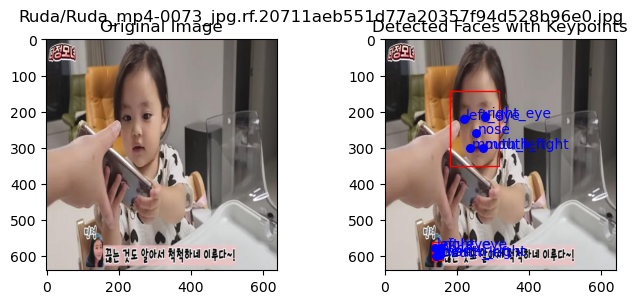

Metadata of detected faces in Ruda/Ruda_mp4-0073_jpg.rf.20711aeb551d77a20357f94d528b96e0.jpg:
Face 1:
   Confidence: 1.00
   Bounding Box: [181, 143, 135, 207]
   Keypoints: {'nose': [253, 259], 'mouth_right': [273, 300], 'right_eye': [279, 215], 'left_eye': [219, 220], 'mouth_left': [235, 301]}

Face 2:
   Confidence: 0.96
   Bounding Box: [131, 561, 30, 49]
   Keypoints: {'nose': [149, 590], 'mouth_right': [152, 598], 'right_eye': [155, 578], 'left_eye': [140, 579], 'mouth_left': [141, 599]}



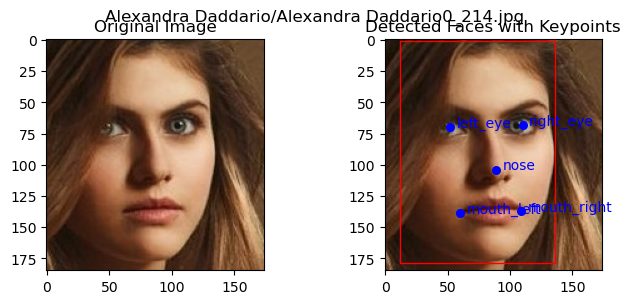

Metadata of detected faces in Alexandra Daddario/Alexandra Daddario0_214.jpg:
Face 1:
   Confidence: 1.00
   Bounding Box: [12, 1, 124, 178]
   Keypoints: {'nose': [89, 104], 'mouth_right': [109, 137], 'right_eye': [110, 68], 'left_eye': [52, 70], 'mouth_left': [60, 139]}



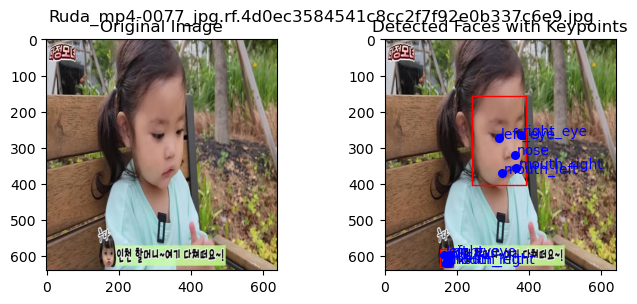

Metadata of detected faces in Ruda_mp4-0077_jpg.rf.4d0ec3584541c8cc2f7f92e0b337c6e9.jpg:
Face 1:
   Confidence: 1.00
   Bounding Box: [154, 580, 34, 51]
   Keypoints: {'nose': [174, 608], 'mouth_right': [178, 620], 'right_eye': [181, 598], 'left_eye': [164, 598], 'mouth_left': [169, 620]}

Face 2:
   Confidence: 0.99
   Bounding Box: [243, 157, 149, 246]
   Keypoints: {'nose': [362, 319], 'mouth_right': [365, 357], 'right_eye': [378, 265], 'left_eye': [316, 273], 'mouth_left': [326, 369]}



In [13]:
from pathlib import Path
import os
import random
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN
from PIL import Image

# Directory paths
train_directory = TRAIN_DIR

# Get a list of all folders in the train directory
all_folders = [folder for folder in train_directory.iterdir() if folder.is_dir()]

# Randomly select two folders
selected_folders = random.sample(all_folders, 2)

# Initialize MTCNN detector
detector = MTCNN()

# Function to detect and display faces
def detect_and_display_faces(image_path: Path, image_title: str) -> None:
    # Read the image
    image = cv2.imread(str(image_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces using MTCNN
    faces = detector.detect_faces(image_rgb)

    # Display image with bounding boxes around detected faces
    plt.figure(figsize=(8, 3))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')

    # Display image with bounding boxes
    plt.subplot(1, 2, 2)
    plt.imshow(image_rgb)

    for face in faces:
        x, y, width, height = face['box']
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        plt.gca().add_patch(rect)

        # Display additional keypoints
        for key, value in face['keypoints'].items():
            plt.scatter(value[0], value[1], s=30, color='blue', marker='o')
            plt.text(value[0] + 5, value[1], key, color='blue')

    plt.title('Detected Faces with Keypoints')
    plt.suptitle(image_title)
    plt.show()

    # Display metadata of detected faces
    print(f"Metadata of detected faces in {image_title}:")
    for i, face in enumerate(faces):
        print(f"Face {i + 1}:")
        print(f"   Confidence: {face['confidence']:.2f}")
        print(f"   Bounding Box: {face['box']}")
        print(f"   Keypoints: {face['keypoints']}")
        print()

# Iterate through selected folders
for folder in selected_folders:
    # Get a list of all images in the folder
    all_images = [img for img in folder.iterdir() if img.suffix.lower() == ".jpg"]

    if not all_images:
        continue

    # Randomly select one image
    selected_image = random.choice(all_images)

    # Detect and display faces for the selected image
    detect_and_display_faces(selected_image, f"{folder.name}/{selected_image.name}")

# Process a deterministic image from the dataset for repeatability
pins_ruda_dir = RAW_DATA_DIR / "Pins_Ruda"
if pins_ruda_dir.exists():
    specified_image_path = next((path for path in pins_ruda_dir.glob("*.jpg")), None)
    if specified_image_path is not None:
        detect_and_display_faces(specified_image_path, specified_image_path.name)
    else:
        print("No JPEG images found in Pins_Ruda directory.")
else:
    print("Pins_Ruda directory not found in RAW_DATA_DIR.")

The extraction of face embeddings involves capturing and encoding facial features into a numerical representation, often in the form of a vector or embedding. These face embeddings serve as compact and distinctive representations of facial characteristics and can be used for tasks like face recognition, verification, and clustering. The process typically involves the following steps:

Face Detection:

Identify and locate faces within an image or video frame. Face detection algorithms, such as MTCNN or Haar cascades, are commonly used for this purpose.

Face Alignment:

Ensure that facial features are aligned consistently across different images. This step helps in reducing variations caused by head pose, tilt, and other factors. Facial landmarks, like the positions of the eyes, nose, and mouth, are often used for alignment.

Preprocessing:

Preprocess the detected faces to enhance the quality of the input for the embedding model. Common preprocessing steps include resizing, normalization, and sometimes data augmentation.

Feature Extraction using Deep Learning:

Employ a deep learning-based face recognition model, often a Convolutional Neural Network (CNN), to extract features from the preprocessed face images. Models such as FaceNet, VGGFace, or OpenFace are popular choices for this task.

Embedding Generation:

The output of the deep learning model is a high-dimensional feature vector (embedding) that represents the unique characteristics of the face. The embedding is a numerical representation in a vector space where similar faces have similar embeddings.

Normalization:

Normalize the embeddings to ensure that they are unit vectors. This can be important for certain distance metrics used in face recognition.

Below demonstrates the vectorization of the face features in a 2 dimensional array. We use MTCNN and a pretrained VGGface model to apply face detection and to extract embeddings.

In [14]:
!pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.9 MB ? eta -:--:--Downloading facenet_pytorch-2.6.0-py3-none-any.whl (1.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/755.5 MB ? eta -:--:--Downloading torch-2.2.2-cp312-cp312-manylinux1_x86_64.whl (755.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 63.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 63.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 47.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 54.0 MB/s eta 0:00:

  0%|          | 0.00/107M [00:00<?, ?B/s]

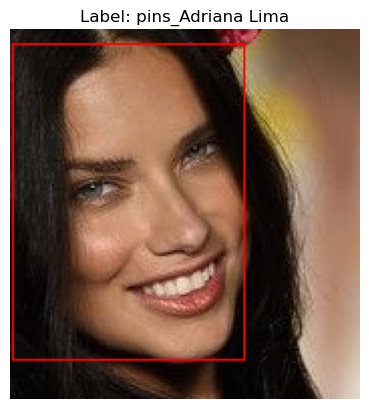

Embeddings for Detected Face 1: [ 4.21621501e-02 -1.35632660e-02  5.19242734e-02  3.65390605e-03
  6.03095815e-02 -2.43074987e-02  6.21922687e-03 -4.21304889e-02
  3.68167181e-03 -2.59302501e-02 -6.35523275e-02 -4.72992919e-02
 -8.00866857e-02 -1.58899799e-02  8.02066848e-02 -3.18778232e-02
  3.84602277e-03 -3.49697061e-02  2.79122572e-02  6.30648881e-02
  1.42952902e-02  1.12388702e-02 -6.18525557e-02  1.18808486e-02
  1.54508781e-02 -9.23253968e-03  8.37083384e-02  2.83665513e-03
  1.75122861e-02 -9.90175828e-02 -6.31612353e-03  6.94921389e-02
  4.09183931e-03  3.24711837e-02  3.87828834e-02  7.96373002e-03
 -4.15280126e-02  2.87337992e-02 -4.22403542e-03  2.13138461e-02
  2.15904564e-02 -9.07378923e-03 -8.85216706e-03 -9.98690277e-02
 -4.12949035e-03 -4.56762724e-02  4.51103747e-02 -4.08284366e-02
  2.74014450e-03  1.65067539e-02  1.15503654e-01  4.80877161e-02
  2.63787247e-02  7.84907937e-02  1.88338105e-02 -4.13236395e-02
  2.44788658e-02  5.95122240e-02  3.49032581e-02  1.037822

In [16]:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from pathlib import Path
from PIL import Image

# Function to process image, detect face, and calculate embeddings
def process_image(image_path: Path, face_detector, face_embedder, label: str) -> None:
    image = cv2.imread(str(image_path))
    if image is None:
        raise FileNotFoundError(f"Unable to read image at {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes, probs = face_detector.detect(image_rgb)

    if boxes is None:
        print(f"No faces detected in {image_path.name}")
        return

    plt.title(f"Label: {label}")
    plt.imshow(Image.fromarray(image_rgb))

    for box in boxes:
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 1)

    plt.imshow(Image.fromarray(image_rgb))
    plt.axis('off')
    plt.show()

    transformed_faces = [face_embedder(extract_face(image_rgb, box).unsqueeze(0)) for box in boxes]
    transformed_faces_np = [face.squeeze().detach().numpy() for face in transformed_faces]

    for idx, embeddings in enumerate(transformed_faces_np, start=1):
        print(f"Embeddings for Detected Face {idx}:", embeddings)

# Select a random image from the raw dataset
identity_folders = [folder for folder in RAW_DATA_DIR.iterdir() if folder.is_dir()]
if not identity_folders:
    raise RuntimeError(f"No identity folders found in {RAW_DATA_DIR}")

selected_folder = random.choice(identity_folders)
image_candidates = list(selected_folder.glob("*.jpg"))
if not image_candidates:
    raise RuntimeError(f"No JPG images found in {selected_folder}")

selected_image_path = random.choice(image_candidates)
label = selected_folder.name[5:] if selected_folder.name.startswith("Pins_") else selected_folder.name

face_detector = MTCNN(margin=20, post_process=False, select_largest=False)
face_embedder = InceptionResnetV1(pretrained='vggface2').eval()

process_image(selected_image_path, face_detector, face_embedder, label=label)

Preferred identity 'Pins_Ruda' not found; randomly selected Alex Lawther instead.
Preferred image not found; randomly selected Alex Lawther60_126.jpg instead.


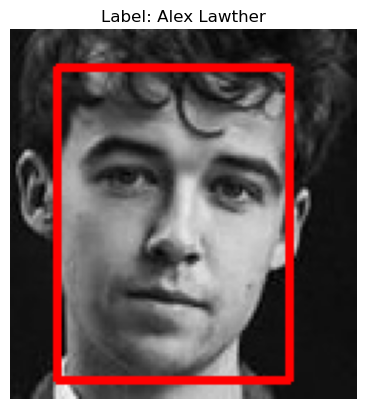

Embeddings for Detected Face 1: [ 4.77926582e-02 -1.52297039e-02  4.09796759e-02  1.68869086e-02
  4.40403149e-02 -6.68288320e-02 -1.36246393e-02 -8.23687948e-03
  1.84750615e-03 -3.70670743e-02 -8.53745788e-02 -4.84829769e-02
 -8.56494680e-02 -1.75625402e-02  7.41991997e-02 -2.87143309e-02
 -6.45080069e-03 -1.93705559e-02  1.70053188e-02  3.63609754e-02
  1.65168680e-02  2.50142571e-02 -4.71868291e-02 -1.18985027e-02
  1.32929794e-02 -7.63444288e-04  8.48473608e-02 -1.55469123e-02
  2.27006469e-02 -9.97529626e-02 -2.71533951e-02  6.09298162e-02
  1.86239537e-02  3.49398851e-02  6.21317700e-02  1.81187838e-02
 -4.93923426e-02  2.96434201e-02 -3.92160155e-02  2.75232289e-02
  8.41074716e-03  1.01612760e-02  4.41089459e-03 -1.13143541e-01
 -1.79593731e-02 -5.07023036e-02  3.49663422e-02 -2.02740673e-02
 -4.42441590e-02  2.85364259e-02  1.08456172e-01  6.55385777e-02
  5.47122546e-02  6.33295327e-02 -8.37433524e-03 -5.89025989e-02
  3.88184711e-02  6.64535835e-02  1.23705342e-03  2.601511

In [20]:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to process image, detect face, and calculate embeddings
def process_image(image_path, face_detector, face_embedder, label):
    image = cv2.imread(str(image_path))
    if image is None:
        raise FileNotFoundError(f"Unable to load image at {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated_rgb = image_rgb.copy()

    boxes, probs = face_detector.detect(image_rgb)

    if boxes is None:
        raise RuntimeError(f"No faces detected in {image_path}")

    plt.title(f"Label: {label}")
    plt.imshow(Image.fromarray(image_rgb))

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        cv2.rectangle(annotated_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    plt.imshow(Image.fromarray(annotated_rgb))
    plt.axis("off")
    plt.show()

    transformed_faces = []
    for box in boxes:
        face_tensor = extract_face(Image.fromarray(image_rgb), box, image_size=160).unsqueeze(0)
        transformed_faces.append(face_embedder(face_tensor))

    transformed_faces_np = [face_tensor.squeeze().detach().numpy() for face_tensor in transformed_faces]

    for i, embeddings in enumerate(transformed_faces_np):
        print(f"Embeddings for Detected Face {i + 1}:", embeddings)

# Prefer a specific identity/image but gracefully fall back if it's missing
preferred_identity = "Pins_Ruda"
preferred_filename = "Ruda_mp4-0123_jpg.rf.9481a17b810052cda075a427a66d4967.jpg"

identity_dirs = [d for d in TRAIN_DIR.iterdir() if d.is_dir()]
if not identity_dirs:
    raise FileNotFoundError(f"No identity folders found in {TRAIN_DIR}")

candidate_dir = next((d for d in identity_dirs if d.name == preferred_identity), None)
if candidate_dir is None:
    candidate_dir = random.choice(identity_dirs)
    print(f"Preferred identity '{preferred_identity}' not found; randomly selected {candidate_dir.name} instead.")
else:
    print(f"Using preferred identity: {candidate_dir.name}")

specified_image_path = candidate_dir / preferred_filename

if not specified_image_path.exists():
    available_images = sorted(candidate_dir.glob("*.jpg"))
    if not available_images:
        raise FileNotFoundError(f"No JPG images found in {candidate_dir}")
    specified_image_path = random.choice(available_images)
    print(f"Preferred image not found; randomly selected {specified_image_path.name} instead.")
else:
    print(f"Using preferred image: {specified_image_path.name}")

label = candidate_dir.name[5:] if candidate_dir.name.startswith("Pins_") else candidate_dir.name

face_detector = MTCNN(margin=20, post_process=False, select_largest=False)
face_embedder = InceptionResnetV1(pretrained='vggface2').eval()

process_image(specified_image_path, face_detector, face_embedder, label=label)

In order to recognize a face from a database of images, we will be comparing the embeddings to a set of other embeddings and calculate the distance between embeddings. If our detection model is set up properly, the shortest distance between two embeddings will allow us to recognize and match with the correct label. Below demonstrates how this distance between two embedding for the same person and for two different people can vary.

Distance calced for different people - We use the Euclidean distance calculcation for this task.

Smaller Euclidean distances indicate more similar embeddings, while larger distances suggest dissimilarity.

In face recognition, the Euclidean distance is often used as a measure of similarity, and a threshold is set to determine if two faces are considered a match or not.

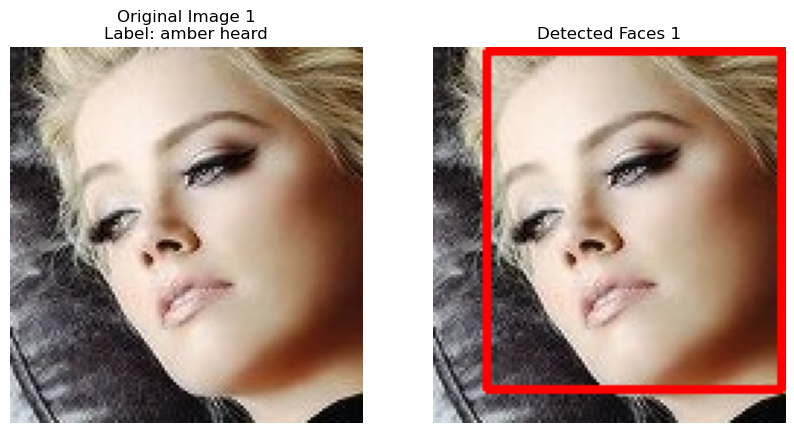

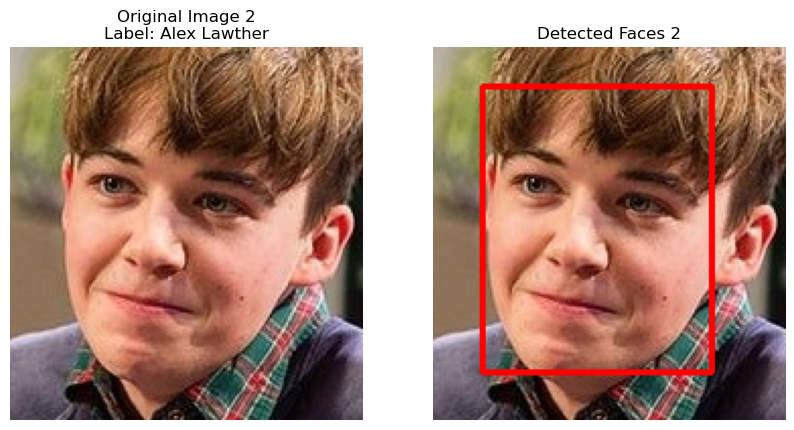

Distance between embeddings: 0.3503


In [25]:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import numpy as np
import random

def process_images(folder_path1, file1, folder_path2, file2, face_detector, face_embedder):
    image1_path = folder_path1 / file1
    image2_path = folder_path2 / file2

    image1 = cv2.imread(str(image1_path))
    if image1 is None:
        raise FileNotFoundError(f"Unable to load image at {image1_path}")
    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

    image2 = cv2.imread(str(image2_path))
    if image2 is None:
        raise FileNotFoundError(f"Unable to load image at {image2_path}")
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    boxes1, _ = face_detector.detect(image1_rgb)
    boxes2, _ = face_detector.detect(image2_rgb)

    if boxes1 is None or len(boxes1) == 0:
        raise RuntimeError(f"No faces detected in {image1_path}")
    if boxes2 is None or len(boxes2) == 0:
        raise RuntimeError(f"No faces detected in {image2_path}")

    label1 = folder_path1.name[5:] if folder_path1.name.startswith("Pins_") else folder_path1.name
    label2 = folder_path2.name[5:] if folder_path2.name.startswith("Pins_") else folder_path2.name

    annotated1 = image1_rgb.copy()
    annotated2 = image2_rgb.copy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(image1_rgb))
    plt.title(f"Original Image 1\nLabel: {label1}")
    plt.axis("off")

    for box in boxes1:
        x1, y1, x2, y2 = box
        cv2.rectangle(annotated1, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(annotated1))
    plt.title("Detected Faces 1")
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(image2_rgb))
    plt.title(f"Original Image 2\nLabel: {label2}")
    plt.axis("off")

    for box in boxes2:
        x1, y1, x2, y2 = box
        cv2.rectangle(annotated2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(annotated2))
    plt.title("Detected Faces 2")
    plt.axis("off")
    plt.show()

    embeddings1 = [face_embedder(extract_face(Image.fromarray(image1_rgb), box, image_size=160).unsqueeze(0)).squeeze().detach().numpy() for box in boxes1]
    embeddings2 = [face_embedder(extract_face(Image.fromarray(image2_rgb), box, image_size=160).unsqueeze(0)).squeeze().detach().numpy() for box in boxes2]

    distance = euclidean_distances(embeddings1[0].reshape(1, -1), embeddings2[0].reshape(1, -1))[0][0]
    print(f"Distance between embeddings: {distance:.4f}")

identity_dirs = [d for d in TRAIN_DIR.iterdir() if d.is_dir()]
if len(identity_dirs) < 2:
    raise RuntimeError(f"Need at least two identity folders in {TRAIN_DIR}")

selected_folders = random.sample(identity_dirs, 2)

def pick_image(folder):
    candidates = sorted(folder.glob("*.jpg"))
    if not candidates:
        raise FileNotFoundError(f"No JPG images found in {folder}")
    return random.choice(candidates).name

file1 = pick_image(selected_folders[0])
file2 = pick_image(selected_folders[1])

face_detector = MTCNN(keep_all=True)
face_embedder = InceptionResnetV1(pretrained='vggface2').eval()

process_images(
    selected_folders[0],
    file1,
    selected_folders[1],
    file2,
    face_detector,
    face_embedder
)

Distance between embeddings calced for the same person.

Selected identity: Anne Hathaway


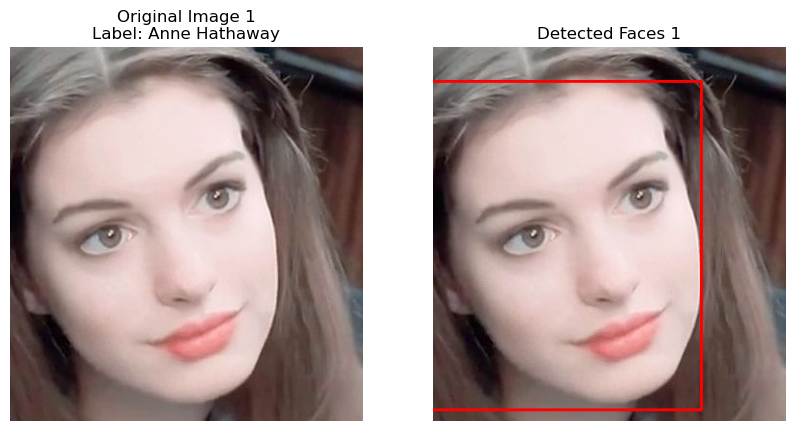

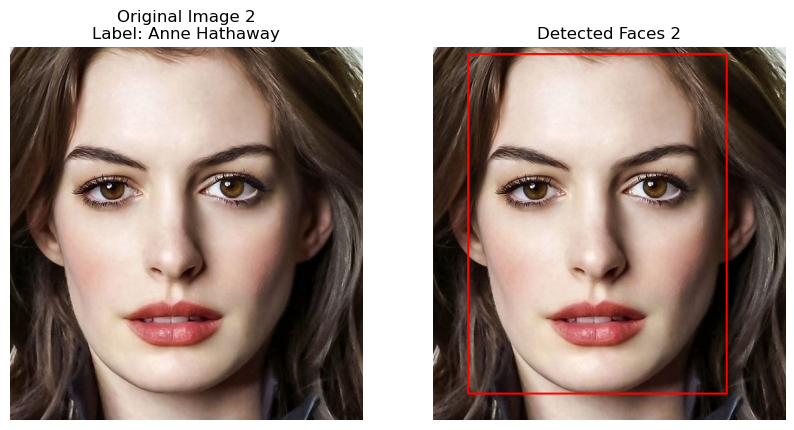

Distance between embeddings: 0.2243


In [26]:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import numpy as np
import random

def pick_two_images(folder_path: Path) -> tuple[Path, Path]:
    candidates = sorted(folder_path.glob("*.jpg"))
    if len(candidates) < 2:
        raise RuntimeError(f"Need at least two JPG images in {folder_path}")
    return tuple(random.sample(candidates, 2))

def show_detection(image_rgb, boxes, title):
    annotated = image_rgb.copy()
    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(annotated, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    plt.imshow(Image.fromarray(annotated))
    plt.title(title)
    plt.axis("off")

def process_single_identity(folder_path: Path, face_detector, face_embedder):
    img_path1, img_path2 = pick_two_images(folder_path)

    image1 = cv2.imread(str(img_path1))
    if image1 is None:
        raise FileNotFoundError(f"Unable to read {img_path1}")
    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

    image2 = cv2.imread(str(img_path2))
    if image2 is None:
        raise FileNotFoundError(f"Unable to read {img_path2}")
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    boxes1, _ = face_detector.detect(image1_rgb)
    boxes2, _ = face_detector.detect(image2_rgb)

    if boxes1 is None or len(boxes1) == 0:
        raise RuntimeError(f"No faces detected in {img_path1}")
    if boxes2 is None or len(boxes2) == 0:
        raise RuntimeError(f"No faces detected in {img_path2}")

    label = folder_path.name[5:] if folder_path.name.startswith("Pins_") else folder_path.name

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(image1_rgb))
    plt.title(f"Original Image 1\nLabel: {label}")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    show_detection(image1_rgb, boxes1, "Detected Faces 1")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(image2_rgb))
    plt.title(f"Original Image 2\nLabel: {label}")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    show_detection(image2_rgb, boxes2, "Detected Faces 2")
    plt.show()

    embeddings1 = [face_embedder(extract_face(Image.fromarray(image1_rgb), box, image_size=160).unsqueeze(0)).squeeze().detach().numpy() for box in boxes1]
    embeddings2 = [face_embedder(extract_face(Image.fromarray(image2_rgb), box, image_size=160).unsqueeze(0)).squeeze().detach().numpy() for box in boxes2]

    distance = euclidean_distances(embeddings1[0].reshape(1, -1), embeddings2[0].reshape(1, -1))[0][0]
    print(f"Distance between embeddings: {distance:.4f}")

identity_dirs = [d for d in TRAIN_DIR.iterdir() if d.is_dir()]
if not identity_dirs:
    raise RuntimeError(f"No identity folders found in {TRAIN_DIR}")

selected_folder = random.choice(identity_dirs)
print(f"Selected identity: {selected_folder.name}")

face_detector = MTCNN(keep_all=True)
face_embedder = InceptionResnetV1(pretrained='vggface2').eval()

process_single_identity(selected_folder, face_detector, face_embedder)

## PREPROCESSING

We will now apply face detection to all the files in our train folder and save the detected faces as separate images under another folder. Some images may not be easy to detect faces so in those cases, we will skip those images.

In [27]:
import os

# Set the directory path
directory_path = DETECTED_FACES_DIR

# Create the folder if it does not exist
directory_path.mkdir(parents=True, exist_ok=True)

print(f"Folder created at: {directory_path}")

Folder created at: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/train_detected_faces


In [28]:
from pathlib import Path
import os
import cv2
import numpy as np

data_directory = TRAIN_DIR
output_directory = DETECTED_FACES_DIR

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces_and_save(image_paths, output_directory):
    processed_images = []
    images_without_faces = 0

    for i, image_path in enumerate(image_paths):
        img = cv2.imread(str(image_path))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        if len(faces) > 0:
            x, y, w, h = faces[0]
            face_roi = img[y:y+h, x:x+w]
            resized_face = cv2.resize(face_roi, (224, 224))

            folder_name = Path(image_path).parent.name
            output_folder = output_directory / folder_name
            output_folder.mkdir(parents=True, exist_ok=True)

            output_path = output_folder / f"detected_face_{i}.jpg"
            cv2.imwrite(str(output_path), resized_face)

            processed_images.append(resized_face)
        else:
            images_without_faces += 1

        if i % 50 == 0:
            print(f"{i}/{len(image_paths)} images processed", end='\r', flush=True)

    print(f"\nImages without faces detected/Total images: {images_without_faces}/{len(image_paths)}")
    return np.array(processed_images)

output_directory.mkdir(parents=True, exist_ok=True)

all_image_paths = []
for folder_name in os.listdir(data_directory):
    folder_path = data_directory / folder_name
    if folder_path.is_dir():
        image_paths = [folder_path / image_name for image_name in os.listdir(folder_path)]
        all_image_paths.extend(image_paths)

X_all_processed = detect_faces_and_save(all_image_paths, output_directory)

print("face detection complete")

1500/1515 images processed
Images without faces detected/Total images: 316/1515
face detection complete

Images without faces detected/Total images: 316/1515
face detection complete


display detected faces - randomly selected

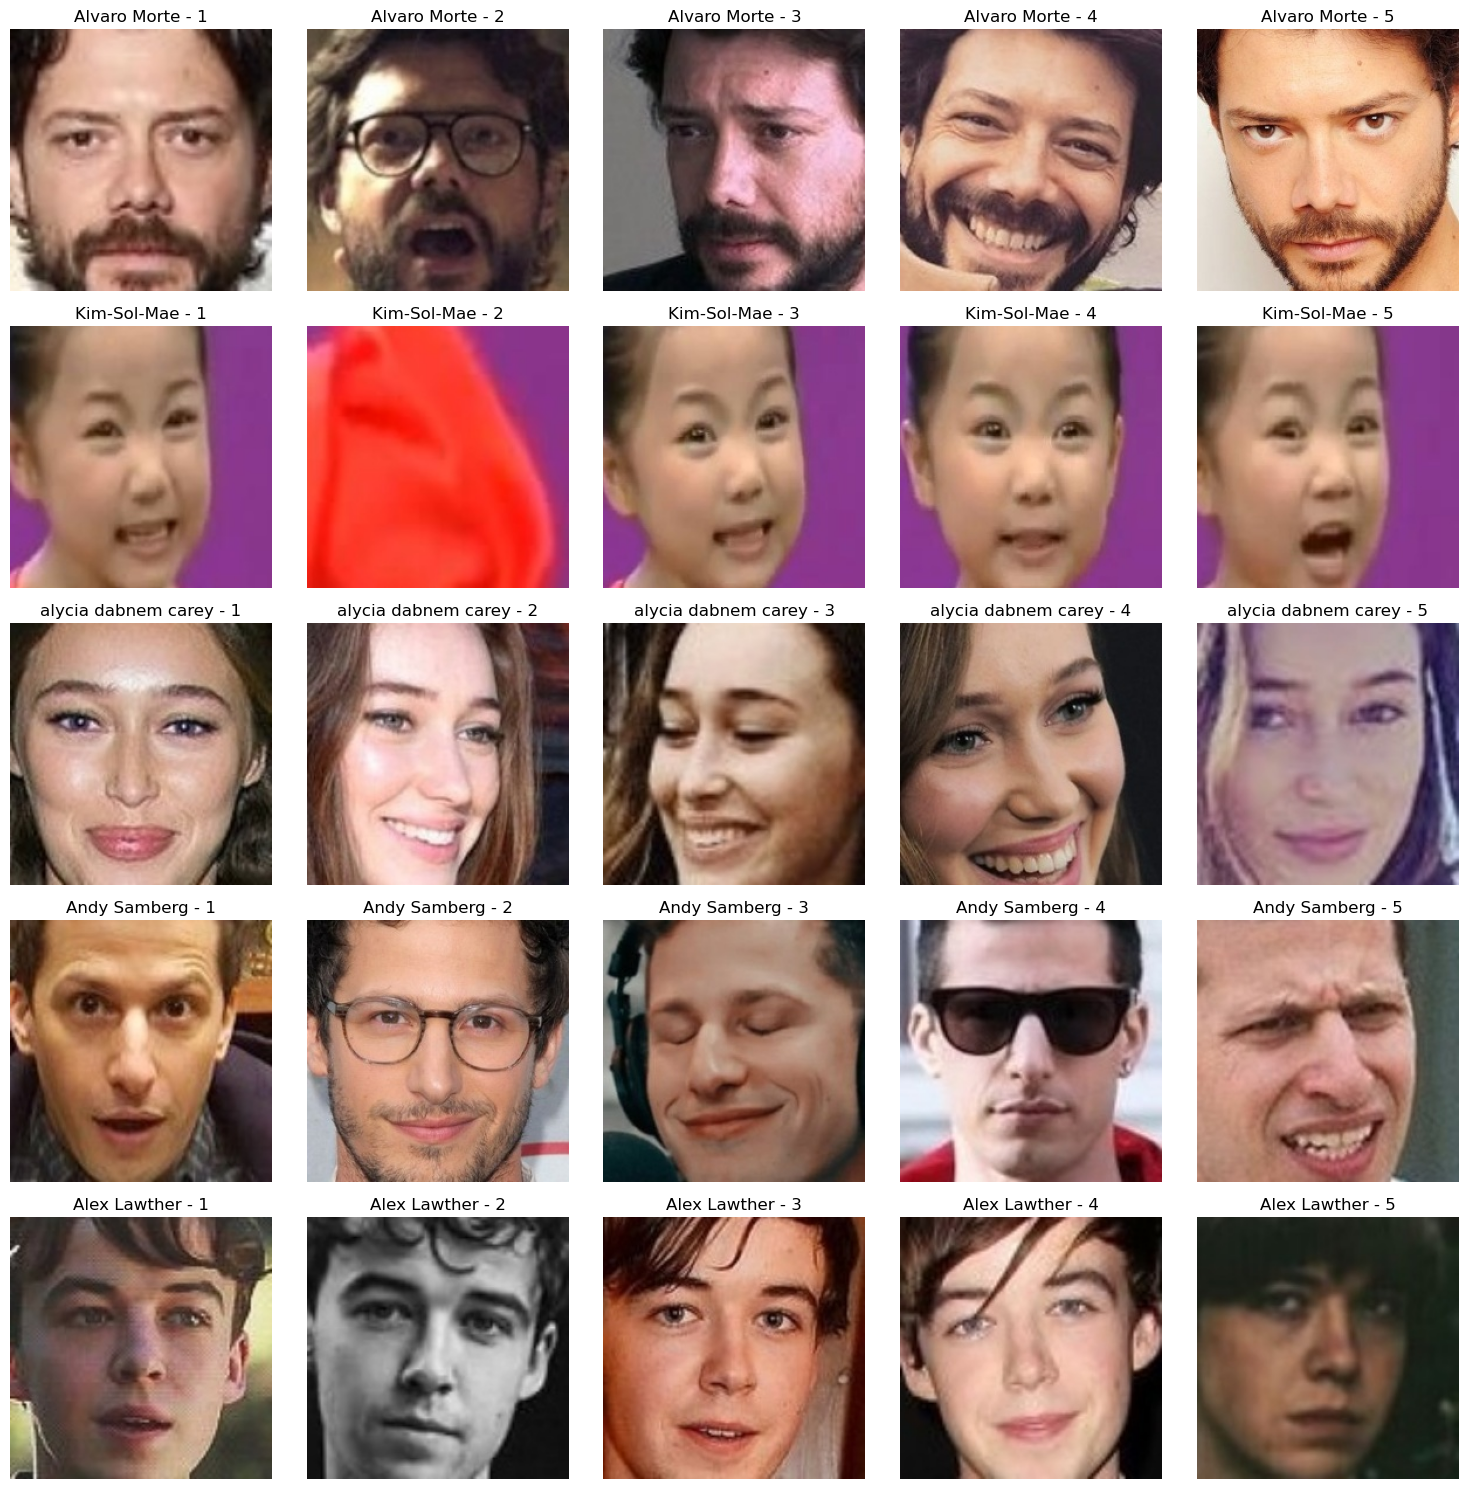

In [29]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Path to detected faces directory
output_directory = DETECTED_FACES_DIR

# Get a list of subdirectories (folders) in the output directory
folders = [f for f in output_directory.iterdir() if f.is_dir()]

if len(folders) < 5:
    raise RuntimeError("Not enough detected face folders to sample from.")

# Randomly pick five folders
selected_folders = np.random.choice(folders, size=5, replace=False)

# Set up the subplot
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

for i, folder_path in enumerate(selected_folders):
    image_paths = list(folder_path.iterdir())[:5]

    for j, image_path in enumerate(image_paths):
        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{folder_path.name} - {j+1}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

lets look at how many files we have under each folder

In [30]:
import os

output_directory = DETECTED_FACES_DIR

# Get a list of all folders under the output directory
all_folders = [folder for folder in output_directory.iterdir() if folder.is_dir()]

# Iterate through each folder and print the folder name and file count
for folder in all_folders:
    file_count = len(list(folder.iterdir()))
    print(f"Folder: {folder.name}, File Count: {file_count}")

Folder: Kim-Sol-Mae, File Count: 30
Folder: Alex Lawther, File Count: 76
Folder: alycia dabnem carey, File Count: 132
Folder: Adriana Lima, File Count: 158
Folder: amber heard, File Count: 143
Folder: Andy Samberg, File Count: 141
Folder: Alvaro Morte, File Count: 77
Folder: Amanda Crew, File Count: 92
Folder: Alexandra Daddario, File Count: 176
Folder: Anne Hathaway, File Count: 135
Folder: Ruda, File Count: 39


In [31]:
!pip install facenet-pytorch

checking embedding distances again between same person vs different people.

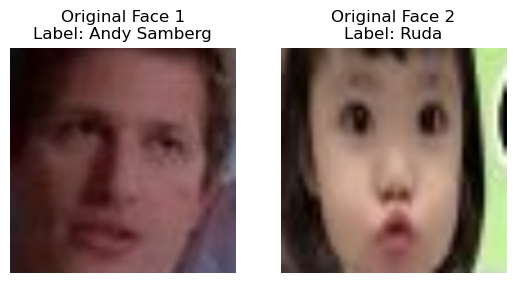

Distance between embeddings: 1.2110


In [32]:
from facenet_pytorch import InceptionResnetV1
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

# Function to process images and calculate embeddings
def process_images(face1_path, face2_path, face_embedder):
    face1 = cv2.imread(str(face1_path))
    face1_rgb = cv2.cvtColor(face1, cv2.COLOR_BGR2RGB)

    face2 = cv2.imread(str(face2_path))
    face2_rgb = cv2.cvtColor(face2, cv2.COLOR_BGR2RGB)

    label1 = face1_path.parent.name
    label2 = face2_path.parent.name

    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(face1_rgb))
    plt.title(f"Original Face 1\nLabel: {label1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(face2_rgb))
    plt.title(f"Original Face 2\nLabel: {label2}")
    plt.axis('off')

    plt.show()

    face1_tensor = torch.from_numpy(face1_rgb.transpose(2, 0, 1)).unsqueeze(0).float() / 255.0
    face2_tensor = torch.from_numpy(face2_rgb.transpose(2, 0, 1)).unsqueeze(0).float() / 255.0

    embeddings1 = face_embedder(face1_tensor).detach().numpy()
    embeddings2 = face_embedder(face2_tensor).detach().numpy()

    distance = euclidean_distances(embeddings1.reshape(1, -1), embeddings2.reshape(1, -1))[0][0]
    print(f"Distance between embeddings: {distance:.4f}")

# Directory paths
train_detected_faces_directory = DETECTED_FACES_DIR

# Randomly pick two folders
selected_folders = random.sample([folder for folder in train_detected_faces_directory.iterdir() if folder.is_dir()], 2)

# Randomly pick one file from each selected folder
file1 = random.choice(list(selected_folders[0].iterdir()))
file2 = random.choice(list(selected_folders[1].iterdir()))

face_embedder = InceptionResnetV1(pretrained='vggface2').eval()

process_images(file1, file2, face_embedder)

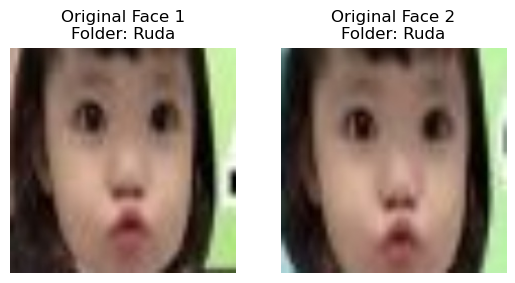

Distance between embeddings: 0.2846


In [33]:
import os
import random
from facenet_pytorch import InceptionResnetV1
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import torch

# Function to process images and calculate embeddings
def process_images(folder_path, face1_file, face2_file, face_embedder):
    face1_path = folder_path / face1_file
    face2_path = folder_path / face2_file

    face1 = cv2.imread(str(face1_path))
    face1_rgb = cv2.cvtColor(face1, cv2.COLOR_BGR2RGB)

    face2 = cv2.imread(str(face2_path))
    face2_rgb = cv2.cvtColor(face2, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(face1_rgb))
    plt.title(f"Original Face 1\nFolder: {folder_path.name}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(face2_rgb))
    plt.title(f"Original Face 2\nFolder: {folder_path.name}")
    plt.axis('off')

    plt.show()

    face1_tensor = torch.from_numpy(face1_rgb.transpose(2, 0, 1)).unsqueeze(0).float() / 255.0
    face2_tensor = torch.from_numpy(face2_rgb.transpose(2, 0, 1)).unsqueeze(0).float() / 255.0

    embeddings1 = face_embedder(face1_tensor).detach().numpy()
    embeddings2 = face_embedder(face2_tensor).detach().numpy()

    distance = euclidean_distances(embeddings1.reshape(1, -1), embeddings2.reshape(1, -1))[0][0]
    print(f"Distance between embeddings: {distance:.4f}")

# Directory paths
train_detected_faces_directory = DETECTED_FACES_DIR

selected_folder = random.choice([folder for folder in train_detected_faces_directory.iterdir() if folder.is_dir()])
files = random.sample(list(selected_folder.iterdir()), 2)
face1_file, face2_file = [f.name for f in files]

face_embedder = InceptionResnetV1(pretrained='vggface2').eval()

process_images(selected_folder, face1_file, face2_file, face_embedder)

## EXTRACTING EMBEDDINGS

In [36]:
import shutil
import os

# Define the path for the extracted embeddings directory within the project
new_folder_path = EMBEDDINGS_DIR

# Create the folder if it does not exist
os.makedirs(new_folder_path, exist_ok=True)

print(f"Embedding repository is available at: {new_folder_path}")

Embedding repository is available at: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddings


Extract face embeddings from detected faces folder and save under a different folder - We will also be applying augmentation to increase the sample size to increase accuracy of our detection model. Data augmentation is a technique used in machine learning and computer vision to artificially increase the diversity of a dataset by applying various transformations to the existing data. In the context of face recognition, data augmentation involves creating new training samples by applying different transformations to the original face images. This process helps improve the generalization and robustness of the face recognition model.

Common data augmentation techniques for face recognition include:

Rotation: Rotating the face images by a certain angle (e.g., 90 degrees, 180 degrees) to simulate variations in head pose.

Flip: Mirroring the face images horizontally to account for left-right asymmetry.

Scaling: Resizing the face images to different scales, simulating variations in distance from the camera.

Translation: Shifting the face images horizontally and vertically to simulate variations in position within the frame.

Noise addition: Introducing random noise to the pixel values to make the model more robust to variations in lighting conditions.

Color jitter: Modifying the color of the face images by adjusting brightness, contrast, and saturation.

Elastic distortion: Applying elastic deformation to the face images to simulate facial expressions and deformations.

By augmenting the training data with these variations, the face recognition model becomes more resilient to different conditions it may encounter during testing. Data augmentation is particularly useful when the size of the original dataset is limited, as it helps prevent overfitting and enhances the model's ability to generalize well to unseen faces.

In [37]:
from pathlib import Path
import torch
from facenet_pytorch import InceptionResnetV1
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Function to extract embeddings from a single folder with data augmentation
def extract_embeddings_from_folder(folder_path, face_embedder, device, output_directory):
    embeddings = {}
    data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ])

    label = folder_path.name

    for image_name in tqdm(os.listdir(folder_path), desc=f"Processing {folder_path}"):
        image_path = folder_path / image_name
        try:
            img = Image.open(image_path)

            img_tensor = transforms.ToTensor()(img).unsqueeze(0).float().to(device)
            embedding = face_embedder(img_tensor).squeeze().detach().cpu().numpy()
            embeddings[image_name] = embedding

            output_emb_path = output_directory / f"{label}_{Path(image_name).stem}_embedding.npy"
            np.save(output_emb_path, embedding)

            augmented_img = data_transform(img)
            img_tensor_augmented = augmented_img.unsqueeze(0).float().to(device)
            embedding_augmented = face_embedder(img_tensor_augmented).squeeze().detach().cpu().numpy()
            embeddings[f"{Path(image_name).stem}_augmented_embedding.npy"] = embedding_augmented

            output_emb_path_augmented = output_directory / f"{label}_{Path(image_name).stem}_augmented_embedding.npy"
            np.save(output_emb_path_augmented, embedding_augmented)

        except Exception as e:
            print(f"Error processing {image_name}: {str(e)}")

    return label, embeddings

# Directory paths
input_directory = DETECTED_FACES_DIR
output_directory = EMBEDDINGS_DIR

# Initialize InceptionResnetV1 for face embedding
device = 'cpu'
face_embedder = InceptionResnetV1(pretrained='vggface2').eval().to(device)

for folder_name in os.listdir(input_directory):
    folder_path = input_directory / folder_name

    if not folder_path.is_dir():
        continue

    label_output_directory = output_directory / folder_name
    label_output_directory.mkdir(parents=True, exist_ok=True)

    label, embeddings = extract_embeddings_from_folder(folder_path, face_embedder, device, label_output_directory)

print("Embeddings extraction complete.")

Processing /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/train_detected_faces/Kim-Sol-Mae: 100%|██████████| 30/30 [00:02<00:00, 10.59it/s]
Processing /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/train_detected_faces/Kim-Sol-Mae: 100%|██████████| 30/30 [00:02<00:00, 10.59it/s]
Processing /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/train_detected_faces/Alex Lawther: 100%|██████████| 76/76 [00:07<00:00, 10.53it/s]
Processing /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/train_detected_faces/Alex Lawther: 100%|██████████| 76/76 [00:07<00:00, 10.53it/s]
Processing /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/train_detected_faces/alycia dabnem carey: 100%|██████████| 132/132 [00:12<00:00, 10.55it/s]
Processing /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Applicat

Embeddings extraction complete.


Review folders and file counts - We have more files after embedding extraction due to augmentation

In [40]:
import os
from pathlib import Path

output_directory = EMBEDDINGS_DIR
if not output_directory.exists():
    raise FileNotFoundError(f"Embedding directory {output_directory} is missing. Run the extraction step first.")

folders_and_counts = []
for folder in sorted(output_directory.iterdir()):
    if folder.is_dir():
        count = sum(1 for _ in folder.iterdir() if _.is_file())
        folders_and_counts.append((folder.name, count))

if not folders_and_counts:
    print(f"No embedding subfolders found under {output_directory}")
else:
    for folder, count in folders_and_counts:
        print(f"Folder: {folder}, Number of Files: {count}")

Folder: Adriana Lima, Number of Files: 316
Folder: Alex Lawther, Number of Files: 152
Folder: Alexandra Daddario, Number of Files: 352
Folder: Alvaro Morte, Number of Files: 154
Folder: Amanda Crew, Number of Files: 184
Folder: Andy Samberg, Number of Files: 282
Folder: Anne Hathaway, Number of Files: 270
Folder: Kim-Sol-Mae, Number of Files: 60
Folder: Ruda, Number of Files: 78
Folder: alycia dabnem carey, Number of Files: 264
Folder: amber heard, Number of Files: 286


We will move 2 images from each folder into a separate test folder to evaluate our face recognition process. We will only move the original embeddings and leave the augmented embeddings in the train folder,

In [42]:
import shutil


import os

# Define the path for the new folder
new_folder_path = 'Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddingstest'

# Create the folder if it does not exist
os.makedirs(new_folder_path, exist_ok=True)

print(f"Folder created at: {new_folder_path}")


Folder created at: Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddingstest


In [47]:
import shutil

source_folder = '/home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddings'
destination_folder = "/home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddingstest"

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Iterate through each folder in the source directory
for folder_name in os.listdir(source_folder):
    folder_path = os.path.join(source_folder, folder_name)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Create the corresponding folder in the destination directory
        destination_folder_path = os.path.join(destination_folder, folder_name)
        os.makedirs(destination_folder_path, exist_ok=True)

        # Get the list of files in the current folder
        files = os.listdir(folder_path)

        # Move the first two files that do not contain "augmented" in their names
        moved_files = 0
        for file_name in files:
            if "augmented" not in file_name:
                source_file_path = os.path.join(folder_path, file_name)
                destination_file_path = os.path.join(destination_folder_path, file_name)

                # Move the file (not copy)
                shutil.move(source_file_path, destination_file_path)
                moved_files += 1

                if moved_files == 2:
                    break  # Break after moving two suitable files

print("Files moved successfully.")


Files moved successfully.


In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=0b6395c8284487c0a0c0efdf6b20222f5070b688817d6340803679da7dcd2bc5
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models


In [ ]:
!pip install facenet-pytorch numpy scikit-learn


## RECOGNIZING FACES-Using Distances between embeddings


We will use two different approaches - First one will be using the distance between embeddings. Second approach we will train and evaluate a classification model using the embeddings.Idea of the classification model will be for the model to learn from the embedings and be able to classify a newly introduced embedding accurately.

Recognizing faces using distance between embeddings. Our process has few steps:

1) We take the average of all embeddings in the train folder including augmented embeddings for the same label and save those average embeddings first.

2) Then we us ethe files in our test folder to calculate teh distance between average embeddings, looping thru all the labels.

3) Shortest distance between teh embeddings of teh test file vs the average embedding should give us the expected match.

4) Predictions are based on the shortest distance.

5) We will show the results by label first and then we will randomly take 40 images and display the actual and predicted labels.

In [48]:
from sklearn.metrics import pairwise_distances

# Function to calculate average embedding for each label
def calculate_average_embeddings(base_folder):
    average_embeddings = {}

    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            label_embeddings = []
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)
                # Load embeddings using your preferred method (e.g., np.load())
                embedding = np.load(file_path)
                label_embeddings.append(embedding)

            # Calculate average embedding for the label
            average_embedding = np.mean(label_embeddings, axis=0)
            average_embeddings[label_folder] = average_embedding

    return average_embeddings

# Function to recognize faces based on existing embeddings
def recognize_faces(test_folder, average_embeddings):
    predictions = []

    for label_folder in os.listdir(test_folder):
        label_path = os.path.join(test_folder, label_folder)
        if os.path.isdir(label_path):
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)

                # Load test embedding from the saved numpy file
                test_embedding = np.load(file_path)

                # Compare test embedding with averaged embeddings
                distances = {}
                for label, avg_embedding in average_embeddings.items():
                    distance = np.linalg.norm(test_embedding - avg_embedding)
                    distances[label] = distance

                # Predict the label with the minimum distance
                predicted_label = min(distances, key=distances.get)
                predictions.append((file_name, label_folder, predicted_label))

    return predictions


# folder paths
base_folder = '/home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddings'
test_folder = '/home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddingstest'

# Load existing average embeddings
average_embeddings = calculate_average_embeddings(base_folder)

# Recognize faces in the test folder
predictions = recognize_faces(test_folder, average_embeddings)

# Print the predictions
for file_name, actual_label, predicted_label in predictions:
    print(f"{file_name}: Actual Label - {actual_label}, Predicted Label - {predicted_label}")


Kim-Sol-Mae_detected_face_19_embedding.npy: Actual Label - Kim-Sol-Mae, Predicted Label - Kim-Sol-Mae
Kim-Sol-Mae_detected_face_1_embedding.npy: Actual Label - Kim-Sol-Mae, Predicted Label - Kim-Sol-Mae
Alex Lawther_detected_face_156_embedding.npy: Actual Label - Alex Lawther, Predicted Label - Alex Lawther
Alex Lawther_detected_face_105_embedding.npy: Actual Label - Alex Lawther, Predicted Label - Alex Lawther
alycia dabnem carey_detected_face_210_embedding.npy: Actual Label - alycia dabnem carey, Predicted Label - alycia dabnem carey
alycia dabnem carey_detected_face_186_embedding.npy: Actual Label - alycia dabnem carey, Predicted Label - alycia dabnem carey
Adriana Lima_detected_face_436_embedding.npy: Actual Label - Adriana Lima, Predicted Label - Adriana Lima
Adriana Lima_detected_face_356_embedding.npy: Actual Label - Adriana Lima, Predicted Label - Adriana Lima
amber heard_detected_face_603_embedding.npy: Actual Label - amber heard, Predicted Label - amber heard
amber heard_dete

Results displayed using the detected faces.Images randomlly selected based on test embeddings.

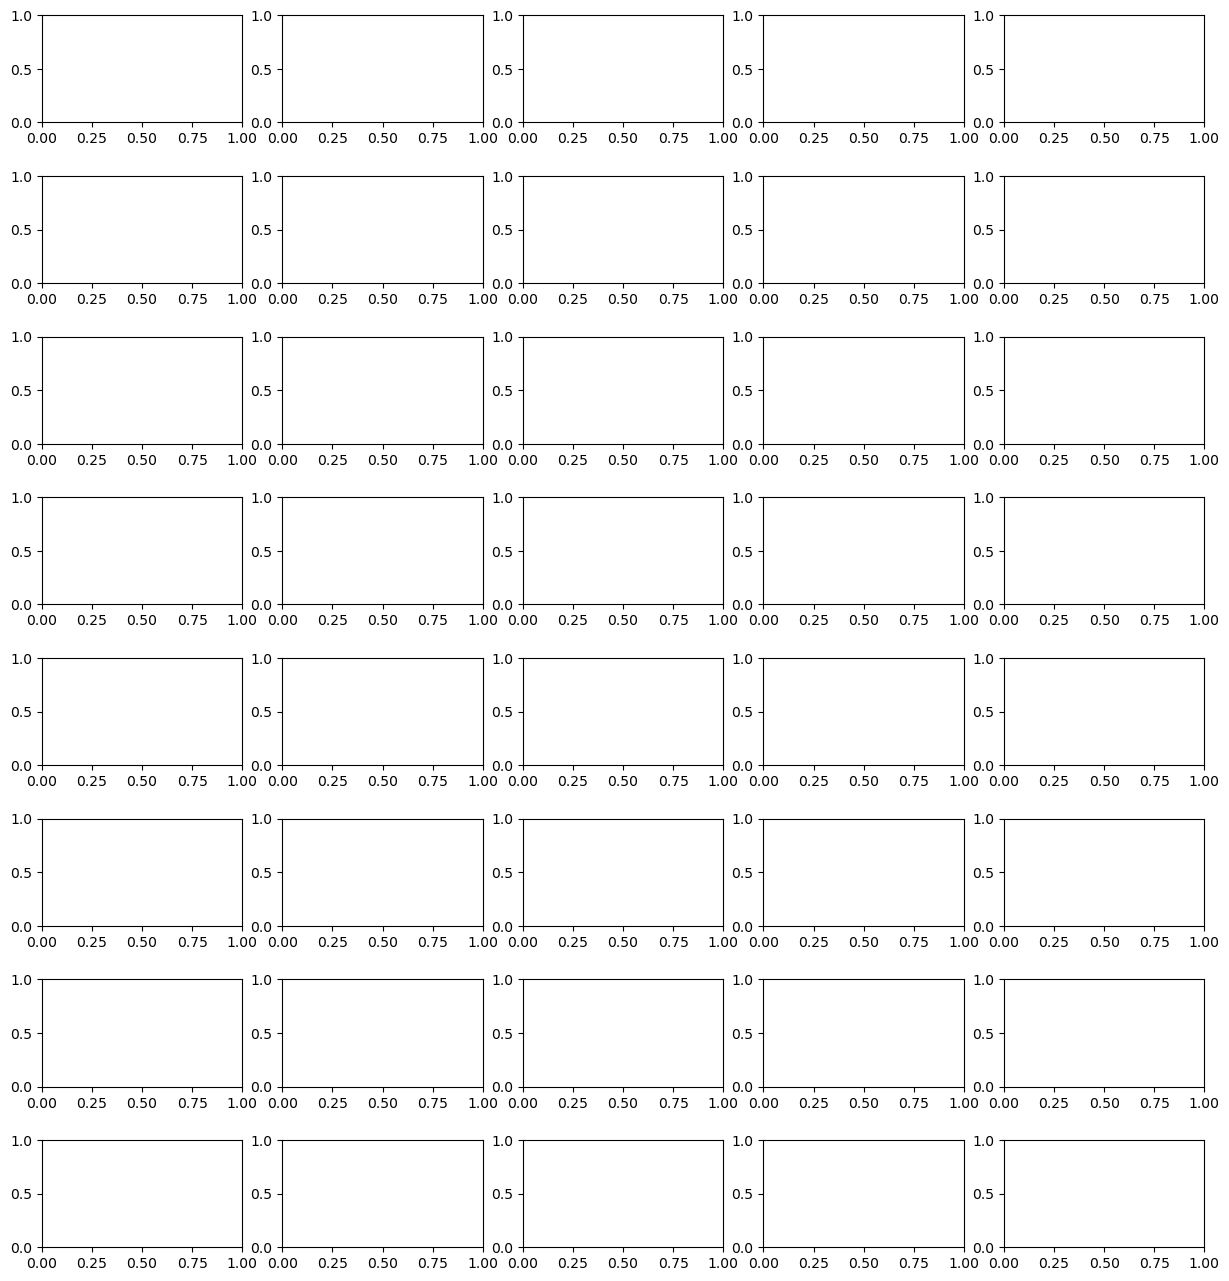

In [46]:

from sklearn.metrics import pairwise_distances
from PIL import Image

# Function to calculate average embedding for each label
def calculate_average_embeddings(base_folder):
    average_embeddings = {}

    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            label_embeddings = []
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)
                # Load embeddings using your preferred method (e.g., np.load())
                embedding = np.load(file_path)
                label_embeddings.append(embedding)

            # Calculate average embedding for the label
            average_embedding = np.mean(label_embeddings, axis=0)
            average_embeddings[label_folder] = average_embedding

    return average_embeddings

# Function to recognize faces based on existing embeddings
def recognize_faces(test_folder, average_embeddings):
    predictions = []

    for label_folder in os.listdir(test_folder):
        label_path = os.path.join(test_folder, label_folder)
        if os.path.isdir(label_path):
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)

                # Load test embedding from the saved numpy file
                test_embedding = np.load(file_path)

                # Compare test embedding with averaged embeddings
                distances = {}
                for label, avg_embedding in average_embeddings.items():
                    distance = np.linalg.norm(test_embedding - avg_embedding)
                    distances[label] = distance

                # Predict the label with the minimum distance
                predicted_label = min(distances, key=distances.get)
                predictions.append((file_name, label_folder, predicted_label))

    return predictions

import random

# Function to display images with actual and predicted labels
def display_random_images(predictions, image_folder, num_images=40):
    selected_predictions = random.sample(predictions, min(num_images, len(predictions)))

    # Calculate the number of rows and columns based on the desired number of images
    num_rows = (num_images + 4) // 5  # Ensure at least 1 row
    num_cols = min(5, num_images)  # Maximum of 5 columns

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 2 * num_rows))
    fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing

    for i, (file_name, actual_label, predicted_label) in enumerate(selected_predictions):
        # Extract identifier from the file name
        identifier_start = file_name.find("_detected_face_") + len("_detected_face_")
        identifier_end = file_name.find("_", identifier_start)
        if identifier_end == -1:
            identifier = file_name[identifier_start:]
        else:
            identifier = file_name[identifier_start:identifier_end]

        # Construct the file path for the corresponding image
        image_name = f"detected_face_{identifier}.jpg"
        image_path = os.path.join(image_folder, actual_label, image_name)

        # Display the actual image along with labels
        try:
            image = Image.open(image_path)
            axes[i // 5, i % 5].imshow(image)
            axes[i // 5, i % 5].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
            axes[i // 5, i % 5].axis('off')

        except FileNotFoundError:
            print(f"Image not found for {identifier}. Skipping to the next one.")

    plt.show()

display_random_images(predictions, '/home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/train_detected_faces', num_images=40)

# folder paths
base_folder = '/home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddings'
test_folder = '/home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddingstest'
image_folder = '/home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/train_detected_faces'

# Load existing average embeddings
average_embeddings = calculate_average_embeddings(base_folder)

# Recognize faces in the test folder
predictions = recognize_faces(test_folder, average_embeddings)

# Display 10 images with actual and predicted labels
#display_images(predictions, image_folder, num_images=10)


Below takes two random embedding files and shows the distance calculations against all the average embeddings for all the labels. You can observe the shortest distance is used to find a match.

In [49]:
def load_test_embeddings(test_folder):
    test_embeddings = []

    for label_folder in os.listdir(test_folder):
        label_path = os.path.join(test_folder, label_folder)
        if os.path.isdir(label_path):
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)

                # Load test embedding from the saved numpy file
                test_embedding = np.load(file_path)
                test_embeddings.append((file_name, label_folder, test_embedding))

    return test_embeddings


# folder paths
base_folder = '/home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddings'
test_folder = '/home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddingstest'

# Load existing average embeddings
average_embeddings = calculate_average_embeddings(base_folder)

# Load test embeddings
test_embeddings = load_test_embeddings(test_folder)

# Randomly pick two test embeddings
random_test_embeddings = random.sample(test_embeddings, 2)

# Print the randomly picked test embeddings
#for file_name, label, test_embedding in random_test_embeddings:
 #   print(f"Randomly Picked Test Embedding ({label}): {test_embedding}")

# Calculate and print distances between the random test embeddings and all average embeddings
for file_name, label, test_embedding in random_test_embeddings:
    print(f"\nDistances for {file_name} ({label}) against Average Embeddings:")
    for avg_label, avg_embedding in average_embeddings.items():
        distance = np.linalg.norm(test_embedding - avg_embedding)
        print(f"  Distance to {avg_label}: {distance}")



Distances for alycia dabnem carey_detected_face_210_embedding.npy (alycia dabnem carey) against Average Embeddings:
  Distance to Kim-Sol-Mae: 1.4020979404449463
  Distance to Alex Lawther: 1.2055736780166626
  Distance to alycia dabnem carey: 0.5856470465660095
  Distance to Adriana Lima: 0.979489803314209
  Distance to amber heard: 0.9740830063819885
  Distance to Andy Samberg: 1.1948333978652954
  Distance to Alvaro Morte: 1.0475866794586182
  Distance to Amanda Crew: 0.8975046873092651
  Distance to Alexandra Daddario: 1.0796505212783813
  Distance to Anne Hathaway: 1.051468849182129
  Distance to Ruda: 1.2471623420715332

Distances for Anne Hathaway_detected_face_1327_embedding.npy (Anne Hathaway) against Average Embeddings:
  Distance to Kim-Sol-Mae: 1.3514796495437622
  Distance to Alex Lawther: 1.3903298377990723
  Distance to alycia dabnem carey: 1.07351553440094
  Distance to Adriana Lima: 1.1019338369369507
  Distance to amber heard: 1.0651843547821045
  Distance to Andy Sa

## RECOGNIZING FACES - Classification model - Multilayered Neural Network

This is an implementation of a neural network for classification using PyTorch deep learning library. Model trains on the embeddings and learns from each embedding for each label and then is evaluated on the test embeddings.

In [ ]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load embeddings and labels
data_dir = "/home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/extracted_embeddings"
embeddings = []
labels = []

for label_folder in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label_folder)
    if os.path.isdir(label_path):
        label = label_folder  # Assuming the folder names are labels
        embeddings_per_label = []

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            if file_name.endswith(".npy"):
                embedding = np.load(file_path)
                embeddings_per_label.append(embedding)
                labels.append(label)

        embeddings.append(embeddings_per_label)

# Flatten the embeddings list
embeddings = [item for sublist in embeddings for item in sublist]

# Convert data to NumPy arrays
X = np.array(embeddings)
labels = np.array(labels)

# Use LabelEncoder to encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data into 80% training, 10% validation, and 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a new model architecture in TensorFlow with Dense layers and Dropout
def create_model(input_size, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_size,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Get the input size and number of classes
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))

# Create the model
model = create_model(input_size, num_classes)

# Compile the model with Adam optimizer and cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

# Train the model
num_epochs = 20
batch_size = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    batch_size=batch_size
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict labels for the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Decode the predicted labels using inverse_transform
predicted_labels = label_encoder.inverse_transform(y_pred)

# Decode the true labels using inverse_transform
true_labels = label_encoder.inverse_transform(y_test)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,195 (676.54 KB)

 Trainable params: 173,195 (676.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5119 - loss: 1.5229 - val_accuracy: 0.9532 - val_loss: 0.4366
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5119 - loss: 1.5229 - val_accuracy: 0.9532 - val_loss: 0.4366
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9087 - loss: 0.3563 - val_accuracy: 0.9872 - val_loss: 0.0979
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9087 - loss: 0.3563 - val_accuracy: 0.9872 - val_loss: 0.0979
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9591 - loss: 0.1621 - val_accuracy: 0.9872 - val_loss: 0.0597
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9591 - loss: 0.1621 - val_accuracy: 0.9872 - val_loss: 0.0597
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9687 - loss: 0.1173 - val_accuracy: 0.9830 - val_loss: 0.0568
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9687 - loss: 0.1173 - val_accuracy: 0.9830 - val_loss: